In [13]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 単回帰

Stan による単回帰モデルの推定方法です。

In [15]:
!cat /content/drive/MyDrive/input/beer-sales-data.csv

sales,temperature
41.68,13.7
110.99,24
65.32,21.5
72.64,13.4
76.54,28.9
62.76,28.9
46.66,12.6
100.79,26.7
85.59,19.4
97.57,21
45.93,21.1
87.47,14.8
72.45,25.2
56.37,13.6
72.84,18.1
75.45,27.1
63.77,29.5
49.06,14.5
68.51,18.9
35.32,11.5
64.18,23.2
69.46,17.8
84.63,26.7
59.02,13
61.44,16.9
55.89,19.8
72.05,13
74.33,17.1
109.04,29.3
30.35,12.6
60.44,10.2
27.81,13.3
77.5,26.2
67.92,27.4
37.63,20.3
103.58,22.5
77.45,26.9
54.98,15.7
72.45,23.3
58.3,13
118.01,29.6
84.97,15.9
33,12.3
32.87,13.3
69.56,28.9
65.95,25.9
123.14,29.5
62.61,17
57.36,20
76.48,26.2
61.37,10.1
49.66,10.3
74.54,23.7
80.26,28.6
45.82,15.5
116.22,26.2
98.35,25.7
124.63,29.8
69.43,22.3
75.24,24.2
68.09,25.4
85.49,27.7
83.33,22.5
78.38,15.2
96.46,27.2
73.59,18.7
82.96,17.8
85.21,19.2
57.6,14.4
36.5,11.3
77.37,15.5
62.58,16.2
72.66,10.8
47.79,13.7
38.59,13.7
90.81,25.1
49.46,15.8
98.08,27.4
39.39,18.1
47.61,21.5
72.85,17
83.46,23.4
59.32,10.5
34.76,18
73.19,14
105.76,27.1
108.98,29.4
73.05,16.5
113.4,24.7
40.19,16.8
85,29.5
7

(100, 2)


,sales,temperature
0,41.68,13.7
1,110.99,24.0
2,65.32,21.5
3,72.64,13.4
4,76.54,28.9


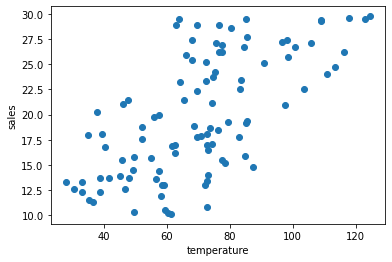

In [16]:
data = pd.read_csv(input_dir+'beer-sales-data.csv')

plt.scatter(data.sales, data.temperature)
plt.xlabel('temperature')
plt.ylabel('sales')

print(data.shape) # 次元を確認
data.head() # データの先頭を確認確認 data.tail() で後ろからも確認できる

In [17]:
# xとyはのちの可視化のため変数として
x = data['temperature'].values # 説明変数の抽出
y = data['sales'].values # 目的変数の抽出
# 以前は tolist() は不要だったが、Stanのバージョンアップと共にと共に
# "Object of type Series is not JSON serializable" とエラーがでるよう
# になった。これはライブラリ内で json.dumps を使っており、その対応可能な型が
# 基本型(str, int, float, bool, None) と dict, list, tuple のみなため
# らしい。そこで、列データ(Series型型)を tolist でリストに変換している。

# Stan に入力するデータを作成
stan_data = {
    'N': data.shape[0], 
    'x': x,
    'y': y
}

stan_data

{'N': 100,
 'x': array([13.7, 24. , 21.5, 13.4, 28.9, 28.9, 12.6, 26.7, 19.4, 21. , 21.1,
        14.8, 25.2, 13.6, 18.1, 27.1, 29.5, 14.5, 18.9, 11.5, 23.2, 17.8,
        26.7, 13. , 16.9, 19.8, 13. , 17.1, 29.3, 12.6, 10.2, 13.3, 26.2,
        27.4, 20.3, 22.5, 26.9, 15.7, 23.3, 13. , 29.6, 15.9, 12.3, 13.3,
        28.9, 25.9, 29.5, 17. , 20. , 26.2, 10.1, 10.3, 23.7, 28.6, 15.5,
        26.2, 25.7, 29.8, 22.3, 24.2, 25.4, 27.7, 22.5, 15.2, 27.2, 18.7,
        17.8, 19.2, 14.4, 11.3, 15.5, 16.2, 10.8, 13.7, 13.7, 25.1, 15.8,
        27.4, 18.1, 21.5, 17. , 23.4, 10.5, 18. , 14. , 27.1, 29.4, 16.5,
        24.7, 16.8, 29.5, 17.9, 17.6, 21.2, 19.3, 13.9, 18.5, 11.9, 12.3,
        18.8]),
 'y': array([ 41.68, 110.99,  65.32,  72.64,  76.54,  62.76,  46.66, 100.79,
         85.59,  97.57,  45.93,  87.47,  72.45,  56.37,  72.84,  75.45,
         63.77,  49.06,  68.51,  35.32,  64.18,  69.46,  84.63,  59.02,
         61.44,  55.89,  72.05,  74.33, 109.04,  30.35,  60.44,  27.81,
         

線形単回帰モデルを、Stanで記述したとき、以下のような式となる。

$$
y[i] = y_{base}[i] + \varepsilon [i] \quad (i = 1, \ldots, N)\\
y_{base}[i] = b_0 + b_1 x[i] \quad (i = 1, \ldots, N)\\
\varepsilon [i]  \sim N(0, \sigma) \quad (i = 1, \ldots, N)
$$

以下、そのモデル式と等価な表現について説明する。上の式から $y_{base}[i]$ を消去すると以下の式になる。

$$
y[i] = b_0 + b_1 x[i] + \varepsilon [i] \quad (i = 1, \ldots, N)\\
\varepsilon [i]  \sim N(\mu, \sigma) \quad (i = 1, \ldots, N)
$$

さらに $\varepsilon [i]$ を消去すると以下の式になる。

$$
y_{base}[i] = b_0 + b_1 x[i] \quad (i = 1, \ldots, N)\\
y[i] \sim N(y_{base}[i], \sigma) \quad (i = 1, \ldots, N)
$$

さらに $y_{base}[i]$ とと $\varepsilon [i]$ を消去すると以下の式になる。

$$
y[i] \sim N(b_0 + b_1 x[i], \sigma) \quad (i = 1, \ldots, N)
$$

以下ののstanでは、一番最後の表現を用いている。

In [30]:
stan_code = """
data {
  int N; // データ数
  vector[N] x; // real x[N]; と書いても同じ。
  vector[N] y; // real y[N]; と書いても同じ。
}

parameters {
  real b0;       // 切片
  real b1;       // 傾き 単回帰なので単独の変数にしているが、重回帰ではここを配列にして使うこともできる。
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}

model {
  for (i in 1:N) {
    y[i] ~ normal (b0 + b1 * x[i], sigma); // 線形単回帰モデル, b0とb1の事前分布は定義していないので-∞から+∞の一様分布
  }
}
"""

In [32]:
model = stan.build(stan_code, data=stan_data, random_seed=1)
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   2% (300/12000)
Sampling:   9% (1100/12000)
Sampling:   9% (1101/12000)
Sampling:  34% (4101/12000)
Sampling:  57% (6801/12000)
Sampling:  75% (9001/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,21.148,6.011,10.471,32.926,0.117,0.084,2632.0,2767.0,1.0
b1,2.461,0.291,1.901,3.007,0.006,0.004,2652.0,2639.0,1.0
sigma,17.111,1.266,14.848,19.643,0.020,0.014,4029.0,3630.0,1.0


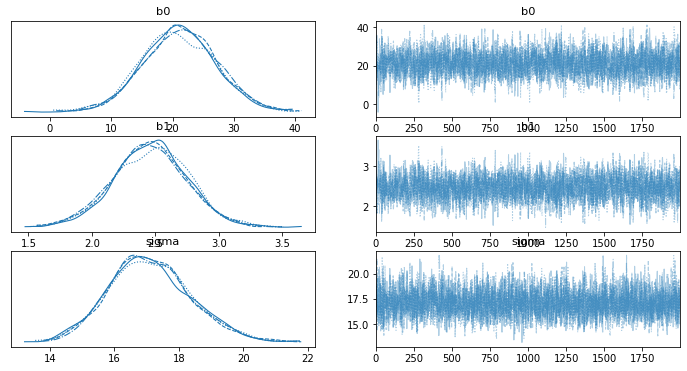

In [48]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit)
summary

In [49]:
result = fit.to_frame()

# 統計量の概要を確認
print(result.describe().T)

# 先頭を表示
result.head()

                count        mean       std         min         25%  \
parameters                                                            
lp__           8000.0 -330.182845  1.266831 -338.039860 -330.768448   
accept_stat__  8000.0    0.933794  0.097268    0.185832    0.912791   
stepsize__     8000.0    0.194614  0.015894    0.169324    0.188861   
treedepth__    8000.0    3.313375  0.949228    1.000000    3.000000   
n_leapfrog__   8000.0   14.723000  8.678461    1.000000    7.000000   
divergent__    8000.0    0.000000  0.000000    0.000000    0.000000   
energy__       8000.0  331.695149  1.759160  328.718232  330.385485   
b0             8000.0   21.148003  6.011009   -4.174675   17.096649   
b1             8000.0    2.460843  0.290933    1.466947    2.268399   
sigma          8000.0   17.111263  1.265511   13.203707   16.240852   

                      50%         75%         max  
parameters                                         
lp__          -329.855427 -329.251390 -328.

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,sigma
draws,,,,,,,,,,
0,-330.332077,0.970480,0.200995,5.0,31.0,0.0,332.027095,27.559828,2.117651,18.696195
1,-328.933992,0.980009,0.195374,3.0,15.0,0.0,329.086996,20.871376,2.417639,17.261849
2,-332.364686,0.613070,0.212764,4.0,15.0,0.0,334.550186,31.654683,2.135622,18.295284
3,-330.636111,1.000000,0.169324,2.0,3.0,0.0,330.997264,25.542444,2.365087,18.664303
4,-330.266102,0.861302,0.200995,5.0,31.0,0.0,332.198914,19.098683,2.691766,17.747382


In [54]:
print(np.mean(result['sigma'])) # 後は変数名で抽出できるので、その後に平均を計算しても上のセルと同じ平均を再計算する例。
print(np.percentile(result['sigma'], 2.5), np.percentile(result['sigma'], 97.5) ) # 95%信頼区間も、 np.percentile が使える。

17.11126258383784
14.76826438693461 19.764529577223183


In [55]:
# パラメータのトレースプロットと事後分布を可視化する関数を自作
def plot_trace(param, param_name='parameter'):  
  mean = np.mean(param) # 平均値（期待値） 
  median = np.median(param) # 中央値
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5) # 95%信頼区間
  
  # トレースプロット
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='red', linestyle='--')
  plt.axhline(median, color='black', linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='gray') # 95%信頼区間の範囲を表記
  plt.axhline(cred_max, linestyle=':', color='gray')
  plt.title('Trace for ' + param_name)
  plt.show()

  # 事後分布
  plt.hist(param, 30, density=True)
  #sns.kdeplot(param, shade=True) # カーネル密度関数を可視化する。。seabornも使えるようになっていると素敵なグラフが作れる。
  plt.axvline(mean, color='red', linestyle='--',label='mean')
  plt.axvline(median, color='black', linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='gray', label='95% CI') # 95%信頼区間の範囲を表記
  plt.axvline(cred_max, linestyle=':', color='gray')  
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.legend()
  plt.title('Posterior Distribution for ' + param_name)
  plt.show()

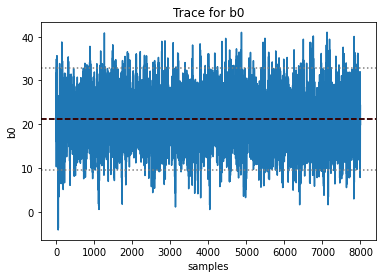

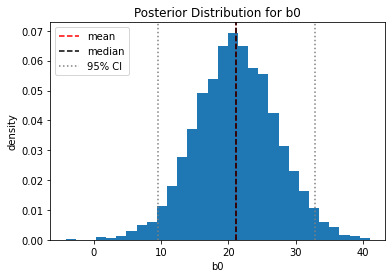

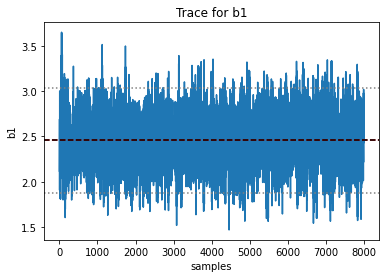

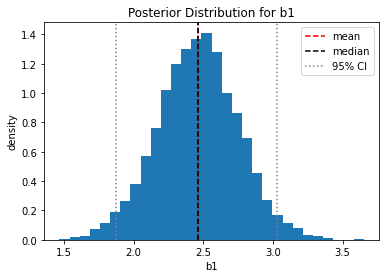

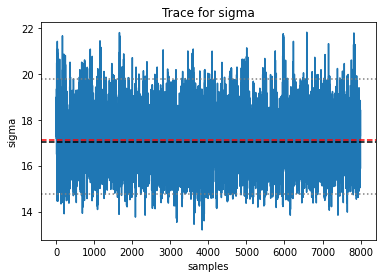

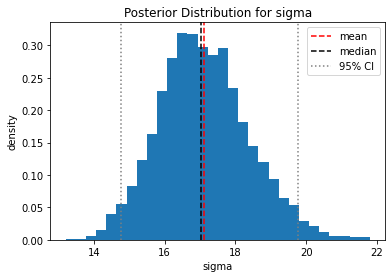

In [56]:
for name in ["b0", "b1", "sigma"]: # result の中で計算するパラメータを指定し、そのパラメータのトレースプロットと事後分布を個別に確認できる
  plot_trace(result[name], name)

Text(0, 0.5, 'sales')

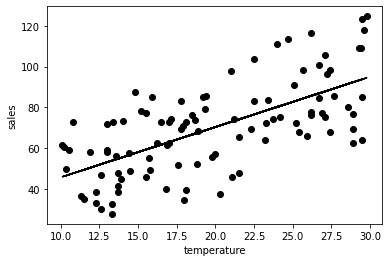

In [57]:
b0, b1 = np.mean(result['b0']), np.mean(result['b1']) 
plt.plot(x, b0 + b1 * np.array(x), color='black') # b0 + b1 * x の計算は、x がリスト型ではできないので、np.array型に変更している。
plt.scatter(x, y, color='black')
plt.xlabel('temperature')
plt.ylabel('sales')


## 単回帰(2)

Stan による単回帰モデルの推定で、予測を行う方法です。
transformed parameters や generated quantities ブロックの使い方も学びます。

In [58]:
x_pred = np.arange(10,41,1) # 予測データとして、10からから41未満の10刻みの等差数列を作成
print (x_pred)

# Stan に入力するデータを新規作成
stan_data2 = {
    'N': data.shape[0], 
    'x': x, 
    'y': y,
    'N_pred': len(x_pred),
    'x_pred': x_pred,
}

stan_data2

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40]


{'N': 100,
 'x': array([13.7, 24. , 21.5, 13.4, 28.9, 28.9, 12.6, 26.7, 19.4, 21. , 21.1,
        14.8, 25.2, 13.6, 18.1, 27.1, 29.5, 14.5, 18.9, 11.5, 23.2, 17.8,
        26.7, 13. , 16.9, 19.8, 13. , 17.1, 29.3, 12.6, 10.2, 13.3, 26.2,
        27.4, 20.3, 22.5, 26.9, 15.7, 23.3, 13. , 29.6, 15.9, 12.3, 13.3,
        28.9, 25.9, 29.5, 17. , 20. , 26.2, 10.1, 10.3, 23.7, 28.6, 15.5,
        26.2, 25.7, 29.8, 22.3, 24.2, 25.4, 27.7, 22.5, 15.2, 27.2, 18.7,
        17.8, 19.2, 14.4, 11.3, 15.5, 16.2, 10.8, 13.7, 13.7, 25.1, 15.8,
        27.4, 18.1, 21.5, 17. , 23.4, 10.5, 18. , 14. , 27.1, 29.4, 16.5,
        24.7, 16.8, 29.5, 17.9, 17.6, 21.2, 19.3, 13.9, 18.5, 11.9, 12.3,
        18.8]),
 'y': array([ 41.68, 110.99,  65.32,  72.64,  76.54,  62.76,  46.66, 100.79,
         85.59,  97.57,  45.93,  87.47,  72.45,  56.37,  72.84,  75.45,
         63.77,  49.06,  68.51,  35.32,  64.18,  69.46,  84.63,  59.02,
         61.44,  55.89,  72.05,  74.33, 109.04,  30.35,  60.44,  27.81,
         

In [76]:
stan_code2 = """
data {
  int N; // 学習データ数
  vector [N] x; // xデータ, real x[N]; でも同じ。
  vector [N] y; // yデータ, real y[N]; でも同じ。
  int N_pred; // 予測データ数
  vector [N_pred] x_pred; // 予測データ, real x_pred[N_pred]; でも同じ。
}

parameters {
  real b0; // 切片
  real b1; // 傾き
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}

transformed parameters { //dataやparametersの値から新たにサンプリングする操作を書く
	vector [N] mu; // real mu[N]; でも同じ。
  
  for (i in 1:N) {
	  mu[i] = b0 + b1 * x[i];
  }
	// mu = b0 + b1 * x; // for 文を省略し左のように書いても同じ。
}

model {
  for (i in 1:N) {
    y[i] ~ normal(mu[i], sigma); // 平均mu、標準偏差sigmaの正規分布. mu[i]を保存する必要がなければ、ここに直接直接 a + b * x[i] を記述しても良い。
  }
  // y ~ normal(mu, sigma); // for 文を省略し左のように書いても同じ。
}

generated quantities { // 推定したパラやデータをを使った操作を記述できる。乱数生成が許される唯一のブロック。このブロックでは　~ を使えないことに注意
  vector [N_pred] mu_pred;  // 期待値、95%ベイズ信用区間に利用。real mu_pred[N_pred]; でも同じ。
  vector [N_pred] y_pred;   // 予測値、95%ベイズ予測区間に利用。real y_pred[N_pred]; でも同じ。

  //mu_pred = b0 + b1 * x_pred; // mu_pred の計算はfor文の外側に出して左のように書いても良い。
  for (i in 1:N_pred) {
    mu_pred[i] = b0 + b1 * x_pred[i];
    // ある分布から乱数を発生させたい場合は、分布名に _rng　をつける。注意：乱数発生させるような場合は for 文なしで、y_pred = normal_rng(mu_pred, sigma); と書くことはできないらしい。
    y_pred[i] = normal_rng(mu_pred[i], sigma);
  }
}
"""

In [77]:
model2 = stan.build(stan_code2, data=stan_data2, random_seed=1)
# MCMCの実行
fit2 = model2.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)


Building...



Building: 36.6s, done.Messages from stanc:
Sampling:   0%
Sampling:   2% (300/12000)
Sampling:   8% (1000/12000)
Sampling:  33% (4000/12000)
Sampling:  56% (6700/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,21.240,5.883,10.211,31.745,0.111,0.079,2786.0,3076.0,1.0
b1,2.458,0.285,1.950,3.002,0.005,0.004,2794.0,3280.0,1.0
sigma,17.031,1.238,14.747,19.392,0.022,0.015,3401.0,3093.0,1.0
mu[0],54.917,2.449,50.377,59.579,0.040,0.029,3674.0,4455.0,1.0
mu[1],80.236,2.131,76.163,84.078,0.027,0.019,6371.0,6082.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[26],109.822,17.806,76.793,143.983,0.205,0.145,7534.0,7606.0,1.0
y_pred[27],112.061,18.046,76.231,143.953,0.209,0.149,7411.0,7229.0,1.0
y_pred[28],114.763,17.735,81.684,147.508,0.204,0.144,7534.0,7930.0,1.0
y_pred[29],116.735,18.220,82.732,151.123,0.220,0.156,6863.0,7481.0,1.0


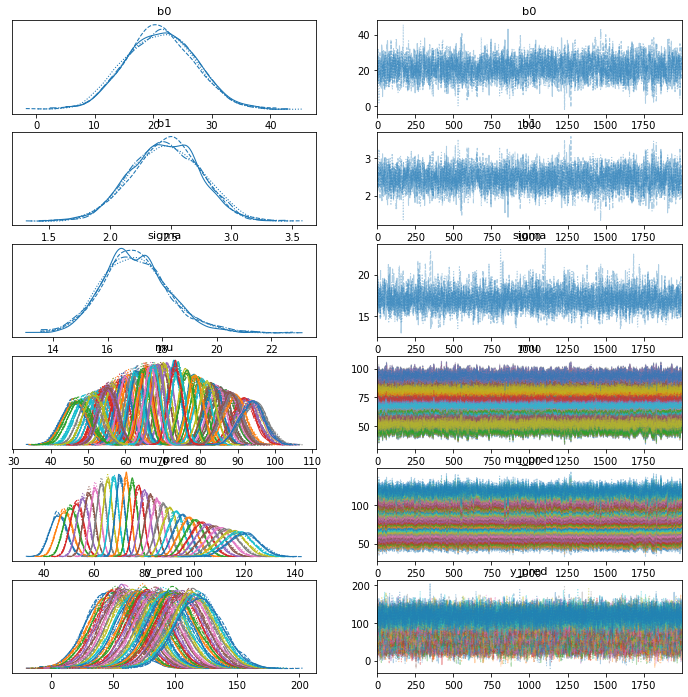

In [78]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit2)

#  Gelman-Rubin 統計量などの簡易表示
summary2 = arviz.summary(fit2)
summary2

In [79]:
result2 = fit2.to_frame()

# 統計量の概要を確認
print(result2.describe().T)

# 先頭を表示
result2.head()

                count        mean        std         min         25%  \
parameters                                                             
lp__           8000.0 -330.163636   1.272836 -341.361242 -330.701199   
accept_stat__  8000.0    0.932053   0.099077    0.128881    0.907437   
stepsize__     8000.0    0.194614   0.015894    0.169324    0.188861   
treedepth__    8000.0    3.287875   0.948612    1.000000    3.000000   
n_leapfrog__   8000.0   14.508000   8.582782    1.000000    7.000000   
...               ...         ...        ...         ...         ...   
y_pred.27      8000.0  109.821661  17.806357   39.010638   97.648856   
y_pred.28      8000.0  112.060850  18.045723   34.080194  100.030225   
y_pred.29      8000.0  114.763413  17.735453   34.500125  103.172349   
y_pred.30      8000.0  116.735273  18.220456   55.513329  104.769708   
y_pred.31      8000.0  119.391713  18.118390   56.836670  107.209793   

                      50%         75%         max  
parameters 

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,sigma,...,y_pred.22,y_pred.23,y_pred.24,y_pred.25,y_pred.26,y_pred.27,y_pred.28,y_pred.29,y_pred.30,y_pred.31
draws,,,,,,,,,,,,,,,,,,,,,
0,-330.332077,0.970480,0.200995,5.0,31.0,0.0,332.027095,27.559828,2.117651,18.696195,...,117.887012,70.238346,106.081580,107.036605,116.651383,122.807829,116.300061,109.592512,102.632976,115.899527
1,-328.933992,0.980009,0.195374,3.0,15.0,0.0,329.086996,20.871376,2.417639,17.261849,...,107.039773,94.263851,98.135372,61.589545,94.168995,102.125936,124.900143,104.172040,139.442973,87.177091
2,-332.364686,0.613070,0.212764,4.0,15.0,0.0,334.550186,31.654683,2.135622,18.295284,...,62.710894,77.702458,103.523984,69.621207,113.671889,126.070720,121.867157,138.579174,101.487102,123.966880
3,-330.636111,1.000000,0.169324,2.0,3.0,0.0,330.997264,25.542444,2.365087,18.664303,...,73.005783,90.529390,120.723832,95.383468,118.768080,86.859503,108.279215,148.580801,146.413043,124.955996
4,-330.621490,0.978971,0.200995,4.0,15.0,0.0,331.465830,11.507588,2.880617,15.771440,...,70.776063,117.753850,132.684171,73.276486,117.590332,116.782627,88.137209,139.946074,125.264235,148.522301


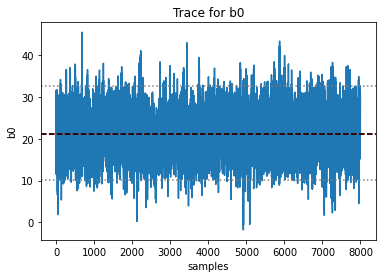

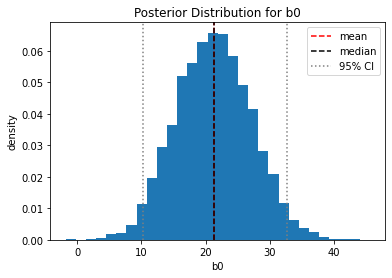

In [121]:
plot_trace(result2['b0'], 'b0') # 前のサンプルと同じようにパラメータを確認できる。

In [120]:
# ただし、mu_pred や y_pred が x_pred 別に計算されていることを確認
list(result2.columns) #列名

['lp__',
 'accept_stat__',
 'stepsize__',
 'treedepth__',
 'n_leapfrog__',
 'divergent__',
 'energy__',
 'b0',
 'b1',
 'sigma',
 'mu.1',
 'mu.2',
 'mu.3',
 'mu.4',
 'mu.5',
 'mu.6',
 'mu.7',
 'mu.8',
 'mu.9',
 'mu.10',
 'mu.11',
 'mu.12',
 'mu.13',
 'mu.14',
 'mu.15',
 'mu.16',
 'mu.17',
 'mu.18',
 'mu.19',
 'mu.20',
 'mu.21',
 'mu.22',
 'mu.23',
 'mu.24',
 'mu.25',
 'mu.26',
 'mu.27',
 'mu.28',
 'mu.29',
 'mu.30',
 'mu.31',
 'mu.32',
 'mu.33',
 'mu.34',
 'mu.35',
 'mu.36',
 'mu.37',
 'mu.38',
 'mu.39',
 'mu.40',
 'mu.41',
 'mu.42',
 'mu.43',
 'mu.44',
 'mu.45',
 'mu.46',
 'mu.47',
 'mu.48',
 'mu.49',
 'mu.50',
 'mu.51',
 'mu.52',
 'mu.53',
 'mu.54',
 'mu.55',
 'mu.56',
 'mu.57',
 'mu.58',
 'mu.59',
 'mu.60',
 'mu.61',
 'mu.62',
 'mu.63',
 'mu.64',
 'mu.65',
 'mu.66',
 'mu.67',
 'mu.68',
 'mu.69',
 'mu.70',
 'mu.71',
 'mu.72',
 'mu.73',
 'mu.74',
 'mu.75',
 'mu.76',
 'mu.77',
 'mu.78',
 'mu.79',
 'mu.80',
 'mu.81',
 'mu.82',
 'mu.83',
 'mu.84',
 'mu.85',
 'mu.86',
 'mu.87',
 'mu.88',
 

In [122]:
# 参考：【pandas】filter：列の抽出【データフレーム処理】 https://datasciencemore.com/python-pandas-filter
# mu_pred.1 ... mu_pred.31 からまでを抽出する方法をテスト
# 正規表現を使って、、mu_predの後ろに 0-9 までの数字が続いたのちに終わる($)、列名 (axis=1) を抽出
print(result2.filter(regex='mu_pred.[0-9]+$', axis=1))


parameters  mu_pred.1  mu_pred.2  mu_pred.3  mu_pred.4  mu_pred.5  mu_pred.6  \
draws                                                                          
0           48.736340  50.853991  52.971642  55.089294  57.206945  59.324596   
1           45.047762  47.465401  49.883039  52.300678  54.718316  57.135955   
2           53.010900  55.146522  57.282143  59.417765  61.553387  63.689008   
3           49.193316  51.558403  53.923490  56.288578  58.653665  61.018752   
4           40.313763  43.194380  46.074997  48.955615  51.836232  54.716850   
...               ...        ...        ...        ...        ...        ...   
7995        51.424339  53.424304  55.424268  57.424233  59.424198  61.424163   
7996        46.022219  48.494866  50.967514  53.440161  55.912808  58.385455   
7997        49.192491  51.628555  54.064619  56.500683  58.936747  61.372812   
7998        49.828886  51.855159  53.881433  55.907707  57.933981  59.960254   
7999        50.087581  52.054216  54.020

In [123]:
# 参考：pandasで分位数・パーセンタイルを取得する https://note.nkmk.me/python-pandas-quantile/
# np.quantile はaxisのデフォルトはaxis=0で列ごとに処理されるが、引数axis=1とすると行ごとの処理となる（数値以外の列は無視される）
mu_pred_95 = np.quantile(result2.filter(regex='mu_pred.[0-9]+$', axis=1), axis=0, q=[0.025,0.975]) # (axix=0)列ごとに95%CIの値を列別に取得
mu_pred_mean = np.average(result2.filter(regex='mu_pred.[0-9]+$', axis=1), axis=0) # (axix=0)列ごとに平均値を取得

print (x_pred)
print (mu_pred_95)
print (mu_mean)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40]
[[ 39.60673897  42.475428    45.37648453  48.20697284  51.02834067
   53.80175889  56.55381883  59.31204919  61.93462999  64.53323565
   67.00189858  69.41312131  71.71706622  73.9506689   76.13075876
   78.20823636  80.2673681   82.32487721  84.35253374  86.33950343
   88.35536776  90.33915654  92.33499239  94.30560384  96.27066428
   98.19944761 100.19579512 102.11963293 104.03863237 106.01031057
  107.9518385 ]
 [ 52.34644757  54.35125981  56.31200871  58.3473046   60.40816284
   62.48183704  64.60213376  66.7679765   68.99494327  71.33328608
   73.77824201  76.27143393  78.90603226  81.66530995  84.43863597
   87.20509152  90.02391521  92.89474633  95.78746445  98.6826267
  101.59723257 104.4950697  107.4291887  110.39718039 113.37255391
  116.30640427 119.2567385  122.23081587 125.16560512 128.09593458
  131.07504643]]
[ 45.82127211  48.27944705  50.737622    53.19579694  55.65397189
  

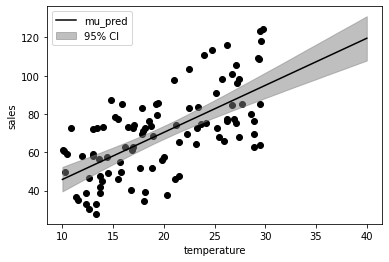

In [115]:
# 回帰直線（平均値）と95%ベイズ信用区間を可視化
plt.scatter(x, y, color='black')
plt.plot(x_pred, mu_pred_mean, color='black', label='mu_pred')
plt.fill_between(x_pred, mu_pred_95[0], mu_pred_95[1], color='gray', alpha=0.5, label='95% CI')
plt.xlabel('temperature')
plt.ylabel('sales')
plt.legend()


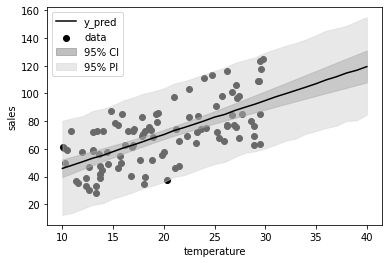

In [129]:
# 予測値の95%ベイズ信用区間と予測区間の比較。
# 回帰直線のベイズ信用区間と比べると、予測区間(PI: Prediction Interval)は幅が広く、予測結果に基づいた判断をするときには注意が必要だとわかる。
y_pred_95 = np.quantile(result2.filter(regex='y_pred.[0-9]+$', axis=1),axis=0, q=[0.025,0.975]) # 事後予測分布の95%信頼区間を x_pred の数だけ抽出
y_pred_mean = np.average(result2.filter(regex='y_pred.[0-9]+$', axis=1), axis=0) # (axix=0)列ごとに平均値を取得

plt.scatter(stan_data2['x'], stan_data2['y'], color='black', label="data")
plt.plot(stan_data2['x_pred'], y_pred_mean, color='black', label='y_pred')
plt.fill_between(x_pred, mu_pred_95[0], mu_pred_95[1], color='gray', alpha=0.5, label='95% CI')
plt.fill_between(stan_data2['x_pred'], y_pred_95[0], y_pred_95[1], color='lightgray', alpha=0.5, label='95% PI')
plt.xlabel('temperature')
plt.ylabel('sales')
plt.legend()
